<a href="https://colab.research.google.com/github/Gauranga2022/DMML-Course-CMI-2023-25/blob/main/DMML_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">
<h2><b>Assignment 1: Classification</b></h2>
<h5><b>CHENNA SAISANDEEP - MDS202319</b></h5>
<h5><b>GAURANGA KUMAR BAISHYA - MDS202325</b></h5>
</div>


In [127]:
# Importing required libraries
import random
import numpy as np
import pandas as pd
import statsmodels.api as sm
import time

# Sklearn modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [83]:
project_start = time.time()

In [84]:
# Set random seeds for NumPy and Python
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [85]:
churn_df = pd.read_csv(
    "/content/customer-churn-data.csv", index_col="CustomerID")
sales_df = pd.read_csv(
    "/content/supermarket-sales-data.csv", index_col='InvoiceID')

### **Helper functions**

In [86]:
# Add two lines above and below a print statement for heading
def decorate_print(func):
    def wrapper(*args, **kwargs):
        print("_"*100)
        func(*args, **kwargs)
        print("_"*100)
    return wrapper


@decorate_print
def print_message(message):
    print(message)


# ROC-AUC Curve
def roc_auc_plot(X_test, y_test, estimator):
    fpr, tpr, _ = roc_curve(
        y_test, estimator.predict_proba(X_test)[:, 1])

    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw,
            label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Confusion matrix plot
def confusion_matrix_plot(y_test, predictions):
    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, predictions),
                annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


def roc_and_confusion(X_test, y_test, predictions, estimator):
    # Plot confusion matrix and ROC curve
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    # Plot confusion matrix using seaborn heatmap
    sns.heatmap(confusion_matrix(y_test, predictions),
                annot=True, fmt="d", cmap="Blues", ax=ax[0])
    ax[0].set_title("Confusion Matrix")
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")

    # Plot ROC curve
    probs_rf = estimator.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, probs_rf)
    roc_auc_rf = roc_auc_score(y_test, probs_rf)
    ax[1].plot(fpr_rf, tpr_rf, label=f'AUC = {roc_auc_rf:.2f}')
    ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax[1].set_title("ROC Curve")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

## **Task 1: Customer Churn**

The customer churn dataset dataset captures customer interactions with an online retail store. This document describes the data fields.

- For this dataset, build two classifiers to predict Churn: one using Adaboost and one using random forest. Use a suitable evaluation metric to compare the performance of the classifiers.


#### **Data exploration**

In [87]:
# Display basic info about the dataset
print_message("Basic Info about the Dataset:")

churn_df.info()

____________________________________________________________________________________________________
Basic Info about the Dataset:
____________________________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   1000 non-null   int64  
 1   Gender                1000 non-null   object 
 2   AnnualIncome          1000 non-null   float64
 3   TotalSpend            1000 non-null   float64
 4   YearsAsCustomer       1000 non-null   int64  
 5   NumOfPurchases        1000 non-null   int64  
 6   AvgTransactionAmount  1000 non-null   float64
 7   NumOfReturns          1000 non-null   int64  
 8   NumOfSupportQueries   1000 non-null   int64  
 9   SatisfactionScore     1000 non-null   int64  
 10  LastPurchaseDaysAgo   1000 non-null   int64 

In [88]:
# Display descriptive statistics
print_message("Descriptive Statistics:")
churn_df.describe()

____________________________________________________________________________________________________
Descriptive Statistics:
____________________________________________________________________________________________________


,Age,AnnualIncome,TotalSpend,YearsAsCustomer,NumOfPurchases,AvgTransactionAmount,NumOfReturns,NumOfSupportQueries,SatisfactionScore,LastPurchaseDaysAgo
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,43.267000,111.962960,5080.79265,9.727000,49.456000,266.876530,4.612000,1.934000,2.974000,182.890000
std,15.242311,52.844111,2862.12335,5.536346,28.543595,145.873445,2.896869,1.402716,1.391855,104.391319
min,18.000000,20.010000,108.94000,1.000000,1.000000,10.460000,0.000000,0.000000,1.000000,1.000000
25%,30.000000,67.800000,2678.67500,5.000000,25.000000,139.682500,2.000000,1.000000,2.000000,93.000000
50%,43.000000,114.140000,4986.19500,9.000000,49.000000,270.100000,5.000000,2.000000,3.000000,180.500000
75%,56.000000,158.452500,7606.47000,14.000000,74.000000,401.602500,7.000000,3.000000,4.000000,274.000000
max,69.000000,199.730000,9999.64000,19.000000,99.000000,499.570000,9.000000,4.000000,5.000000,364.000000


In [89]:
churn_df.head()

,Age,Gender,AnnualIncome,TotalSpend,YearsAsCustomer,NumOfPurchases,AvgTransactionAmount,NumOfReturns,NumOfSupportQueries,SatisfactionScore,LastPurchaseDaysAgo,EmailOptIn,PromotionResponse,Churn
CustomerID,,,,,,,,,,,,,,
1,62,Other,45.15,5892.58,5,22,453.80,2,0,3,129,True,Responded,True
2,65,Male,79.51,9025.47,13,77,22.90,2,2,3,227,False,Responded,False
3,18,Male,29.19,618.83,13,71,50.53,5,2,2,283,False,Responded,True
4,21,Other,79.63,9110.30,3,33,411.83,5,3,5,226,True,Ignored,True
5,21,Other,77.66,5390.88,15,43,101.19,3,0,5,242,False,Unsubscribed,False


In [90]:
# Check unique values in categorical columns
categorical_columns = ['Gender', 'EmailOptIn', 'PromotionResponse', 'Churn']
for col in categorical_columns:
    print_message(f"Unique values in {col}")
    print(churn_df[col].value_counts())

____________________________________________________________________________________________________
Unique values in Gender
____________________________________________________________________________________________________
Female    342
Male      334
Other     324
Name: Gender, dtype: int64
____________________________________________________________________________________________________
Unique values in EmailOptIn
____________________________________________________________________________________________________
True     529
False    471
Name: EmailOptIn, dtype: int64
____________________________________________________________________________________________________
Unique values in PromotionResponse
____________________________________________________________________________________________________
Unsubscribed    361
Responded       338
Ignored         301
Name: PromotionResponse, dtype: int64
___________________________________________________________________________________

We can observe that the Churn is not perfectly balanced but this dataset not completely imbalanced aswell.

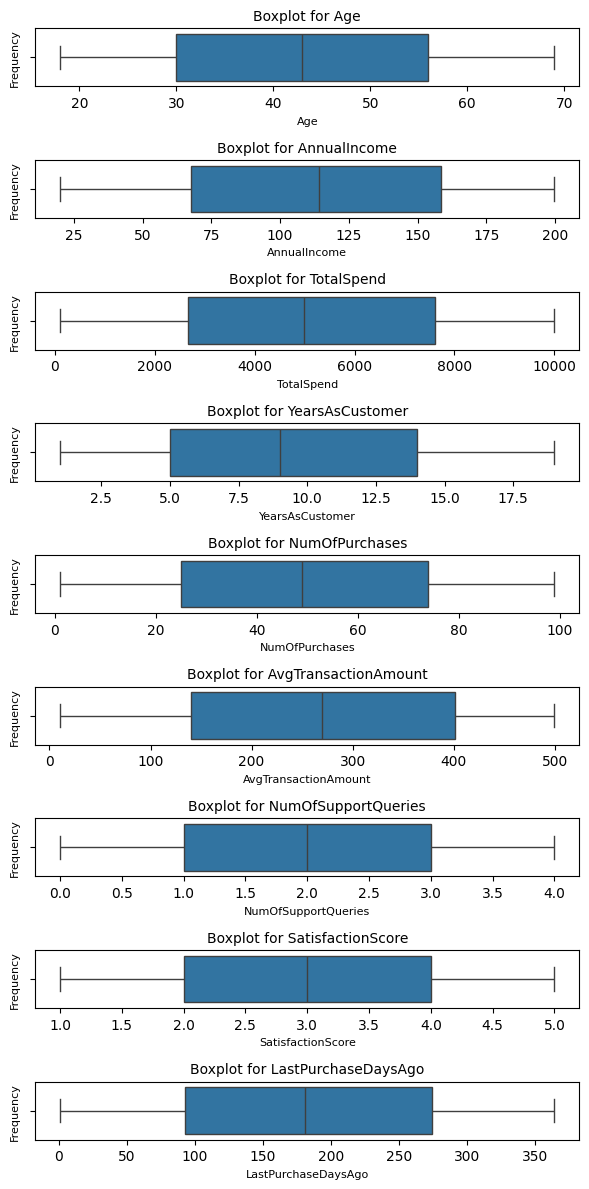

In [91]:
numerical_columns = ['Age', 'AnnualIncome',
                     'TotalSpend', 'YearsAsCustomer', 'NumOfPurchases', 'AvgTransactionAmount', 'NumOfSupportQueries', 'SatisfactionScore', 'LastPurchaseDaysAgo']
# Define the number of subplots you want
nplots = len(numerical_columns)

# Define the figure size
figsize = (6, 12)

# Create a figure
fig, axes = plt.subplots(nrows=nplots, ncols=1, figsize=figsize)

# Iterate over all subplots
for i, column in enumerate(numerical_columns):
    sns.boxplot(x=churn_df[column], ax=axes[i])
    axes[i].set_title('Boxplot for {}'.format(column), fontsize=10)
    axes[i].set_xlabel(column, fontsize=8)
    axes[i].set_ylabel('Frequency', fontsize=8)

fig.tight_layout()

plt.show()

#### **Data preprocessing**

In [92]:
# Encode categorical variables
churn_data_encoded = pd.get_dummies(churn_df, columns=['Gender'], drop_first=True)

# Convert PromotionResponse, EmailOptIn, and Churn to numeric values
churn_data_encoded['PromotionResponse'] = churn_data_encoded["PromotionResponse"].replace(
    {'Responded': -1, 'Ignored': 0, 'Unsubscribed': 1})
churn_data_encoded['EmailOptIn'] = churn_data_encoded['EmailOptIn'].replace({True: 0, False: 1})
churn_data_encoded['Churn'] = churn_data_encoded['Churn'].replace({True: 1, False: 0})

# Standardize numerical features
scaler = StandardScaler()
# Scale all features except the target variable (Churn)
churn_scaled_data = scaler.fit_transform(churn_data_encoded.drop("Churn", axis=1))

# Convert the scaled NumPy array back to a DataFrame
churn_scaled_df = pd.DataFrame(
    churn_scaled_data, columns=churn_data_encoded.drop("Churn", axis=1).columns, index=churn_data_encoded.index)

# Add the target variable (Churn) back to the DataFrame
churn_scaled_df['Churn'] = churn_data_encoded['Churn']

# Display the first few rows of the DataFrame
print_message("Head of scaled Churn dataframe")
churn_scaled_df.head()

____________________________________________________________________________________________________
Head of scaled Churn dataframe
____________________________________________________________________________________________________


,Age,AnnualIncome,TotalSpend,YearsAsCustomer,NumOfPurchases,AvgTransactionAmount,NumOfReturns,NumOfSupportQueries,SatisfactionScore,LastPurchaseDaysAgo,EmailOptIn,PromotionResponse,Gender_Male,Gender_Other,Churn
CustomerID,,,,,,,,,,,,,,,
1,1.229628,-1.264973,0.283773,-0.854240,-0.962378,1.282050,-0.902114,-1.379444,0.018689,-0.516489,-0.943588,-1.224056,-0.708168,1.444444,1
2,1.426547,-0.614434,1.378924,0.591480,0.965463,-1.673359,-0.902114,0.047075,0.018689,0.422756,1.059784,-1.224056,1.412095,-0.692308,0
3,-1.658518,-1.567145,-1.559749,0.591480,0.755153,-1.483853,0.134005,0.047075,-0.700136,0.959468,1.059784,-1.224056,1.412095,-0.692308,1
4,-1.461599,-0.612162,1.408578,-1.215669,-0.576810,0.994191,0.134005,0.760335,1.456339,0.413172,-0.943588,-0.027520,-0.708168,1.444444,1
5,-1.461599,-0.649460,0.108396,0.952910,-0.226294,-1.136392,-0.556741,-1.379444,1.456339,0.566518,1.059784,1.169016,-0.708168,1.444444,0


In [93]:
# PCA
np.random.seed(42)
n_components = churn_scaled_df.shape[1]-1
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(churn_scaled_df.drop("Churn", axis=1))

# Create a new DataFrame to store PCA results
pca_df = pd.DataFrame(pca_result, columns=[
                      f"PCA{i+1}" for i in range(n_components)], index=churn_scaled_df.index)

# Concatenate the PCA DataFrame with the Churn column
pca_df['Churn'] = churn_scaled_df['Churn']

explained_variance = pca.explained_variance_ratio_

print_message("Amount of variance captured by each component")

# Print the explained variance
for i, exp_var in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {exp_var*100:.2f}% of the variance")

____________________________________________________________________________________________________
Amount of variance captured by each component
____________________________________________________________________________________________________
Principal Component 1: 11.12% of the variance
Principal Component 2: 8.37% of the variance
Principal Component 3: 7.95% of the variance
Principal Component 4: 7.82% of the variance
Principal Component 5: 7.56% of the variance
Principal Component 6: 7.41% of the variance
Principal Component 7: 7.16% of the variance
Principal Component 8: 6.91% of the variance
Principal Component 9: 6.75% of the variance
Principal Component 10: 6.49% of the variance
Principal Component 11: 6.44% of the variance
Principal Component 12: 6.31% of the variance
Principal Component 13: 6.11% of the variance
Principal Component 14: 3.59% of the variance


The variance explained by each principal component decreases gradually and there isn’t a clear point where the amount of explained variance drops significantly. This suggests that the data is distributed fairly evenly across all dimensions and there isn’t a smaller subset of features that captures most of the variance in the data.

Since all components contribute to the variance almost equally, it's better to use all of them for the downstream tasks

#### **Model fitting**

In [94]:
# Set random seeds for NumPy and Python
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)


# Split the data into training and testing sets
X = churn_data_encoded.drop('Churn', axis=1)
y = churn_data_encoded['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20)

##### Random Forest

____________________________________________________________________________________________________
Random Forest
____________________________________________________________________________________________________

Best Random Forest Hyperparameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 250}
Best Random Forest Accuracy: 0.630600138165058


Random Forest Test Accuracy: 0.585


Random Forest Classifier Evaluation:
              precision    recall  f1-score   support

           0       0.65      0.26      0.37        94
           1       0.57      0.88      0.69       106

    accuracy                           0.58       200
   macro avg       0.61      0.57      0.53       200
weighted avg       0.61      0.58      0.54       200



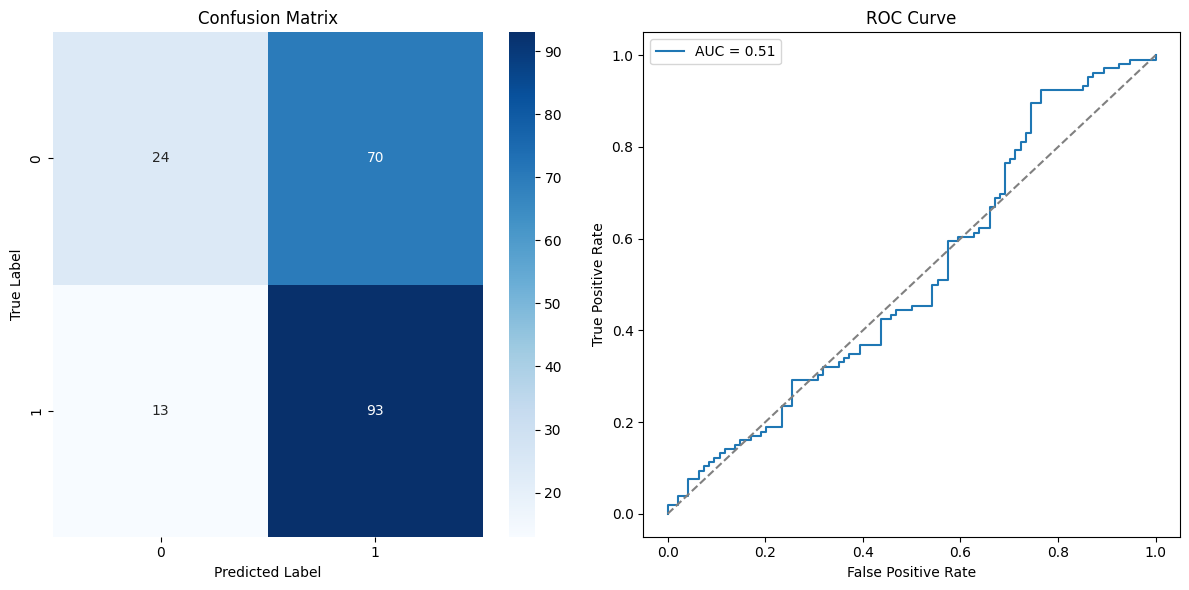

In [95]:
# Random Forest
start = time.time()
rf_classifier = RandomForestClassifier(random_state=random_seed)

# Define hyperparameters for grid search
rf_param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [None, 5, 8, 10],
    'min_samples_split': [3, 5, 10]
}

# Perform grid search cross-validation
rf_grid_search = GridSearchCV(
    rf_classifier, rf_param_grid, cv=10, scoring='f1', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
end = time.time()
customer_churn_rf = end - start

print_message("Random Forest")

# Best hyperparameters and accuracy score
print("\nBest Random Forest Hyperparameters:", rf_grid_search.best_params_)
print("Best Random Forest Accuracy:", rf_grid_search.best_score_)
print('\n')

# Evaluation on the test set
rf_predictions = rf_grid_search.best_estimator_.predict(X_test)
rf_test_accuracy = accuracy_score(
    y_test, rf_predictions)

print("Random Forest Test Accuracy:", rf_test_accuracy)
print('\n')

print("Random Forest Classifier Evaluation:")
print(classification_report(y_test, rf_predictions))

# Plot confusion matrix and AUC-ROC curve
roc_and_confusion(X_test, y_test, rf_predictions,
                  rf_grid_search.best_estimator_)

#### AdaBoost

____________________________________________________________________________________________________
AdaBoost
____________________________________________________________________________________________________

Best AdaBoost Hyperparameters: {'learning_rate': 0.01, 'n_estimators': 100}
Best AdaBoost Accuracy: 0.6163076208052722


AdaBoost Test accuracy: 0.595

AdaBoost Classifier Evaluation:
              precision    recall  f1-score   support

           0       0.72      0.22      0.34        94
           1       0.57      0.92      0.71       106

    accuracy                           0.59       200
   macro avg       0.65      0.57      0.52       200
weighted avg       0.64      0.59      0.54       200



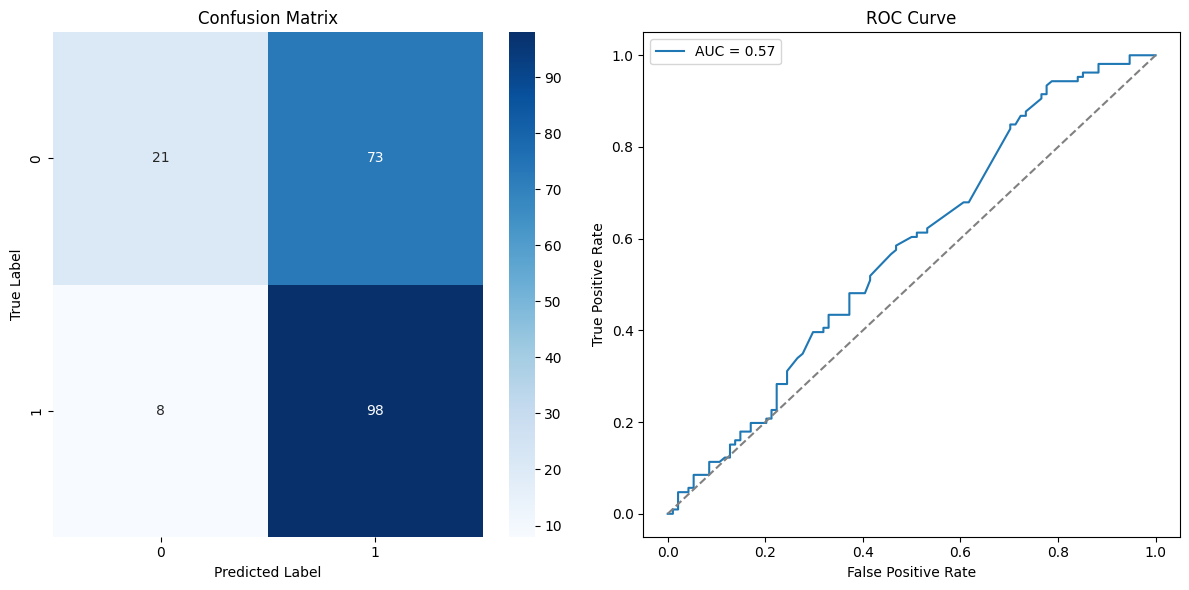

In [96]:
# AdaBoost
start = time.time()
ada_classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3), random_state=random_seed)

# Define hyperparameters for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 1],
}

# Perform GridSearchCV
ada_grid_search = GridSearchCV(ada_classifier, param_grid,
                               cv=10, scoring='f1', n_jobs=-1)
ada_grid_search.fit(X_train, y_train)
end = time.time()
customer_churn_ab = end-start
print_message("AdaBoost")

# Print best parameters and best score
print("\nBest AdaBoost Hyperparameters:", ada_grid_search.best_params_)
print("Best AdaBoost Accuracy:", ada_grid_search.best_score_)
print("\n")


# Evalution on the test set
ada_predictions = ada_grid_search.best_estimator_.predict(X_test)
ada_test_accuray = accuracy_score(y_test, ada_predictions)

print("AdaBoost Test accuracy:", accuracy_score(y_test, ada_predictions))
# Evaluate AdaBoost Classifier
print("\nAdaBoost Classifier Evaluation:")
print(classification_report(y_test, ada_predictions))

# Plot confusion matrix and AUC-ROC curve
roc_and_confusion(X_test, y_test, ada_predictions,
                  ada_grid_search.best_estimator_)

## **Task 2 : Supermarket sales**

The supermarket sales dataset has sales data for a supermarket with three branches. This document describes the data fields.

You have two tasks for this dataset.

1. Build two classifiers to predict Gender, one using a decision tree and one using a random forest. Use a suitable evaluation metric to compare the performance of the classifiers.

2. Build two models to predict Rating, one using linear regression and one using a decision tree regressor. Use a suitable evaluation metric to compare the performance of the models.


#### **Data Exploration**

In [97]:
# Display basic info about the dataset
print_message("Basic Info about the Dataset:")
sales_df.info()

____________________________________________________________________________________________________
Basic Info about the Dataset:
____________________________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 750-67-8428 to 849-09-3807
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Branch        1000 non-null   object 
 1   CustomerType  1000 non-null   object 
 2   Gender        1000 non-null   object 
 3   ProductType   1000 non-null   object 
 4   UnitPrice     1000 non-null   float64
 5   Quantity      1000 non-null   int64  
 6   Tax           1000 non-null   float64
 7   Total         1000 non-null   float64
 8   PaymentType   1000 non-null   object 
 9   Rating        1000 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 85.9+ KB


In [98]:
# Display descriptive statistics
print_message("Descriptive Statistics:")
sales_df.describe()

____________________________________________________________________________________________________
Descriptive Statistics:
____________________________________________________________________________________________________


,UnitPrice,Quantity,Tax,Total,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,6.97270
std,26.494628,2.923431,11.708825,245.885335,1.71858
min,10.080000,1.000000,0.508500,10.678500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,5.50000
50%,55.230000,5.000000,12.088000,253.848000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,10.00000


In [99]:
sales_df.head()

,Branch,CustomerType,Gender,ProductType,UnitPrice,Quantity,Tax,Total,PaymentType,Rating
InvoiceID,,,,,,,,,,
750-67-8428,A,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,UPI,9.1
226-31-3081,C,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,Cash,9.6
631-41-3108,A,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,Credit card,7.4
123-19-1176,A,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,UPI,8.4
373-73-7910,A,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,UPI,5.3


In [100]:
sales_categorical_columns = ["Branch", "CustomerType", "Gender", "ProductType", "PaymentType"]
for col in sales_categorical_columns:
    print_message(f"Unique values in {col}")
    print(sales_df[col].value_counts())

____________________________________________________________________________________________________
Unique values in Branch
____________________________________________________________________________________________________
A    340
B    332
C    328
Name: Branch, dtype: int64
____________________________________________________________________________________________________
Unique values in CustomerType
____________________________________________________________________________________________________
Member    501
Normal    499
Name: CustomerType, dtype: int64
____________________________________________________________________________________________________
Unique values in Gender
____________________________________________________________________________________________________
Female    501
Male      499
Name: Gender, dtype: int64
____________________________________________________________________________________________________
Unique values in ProductType
________________

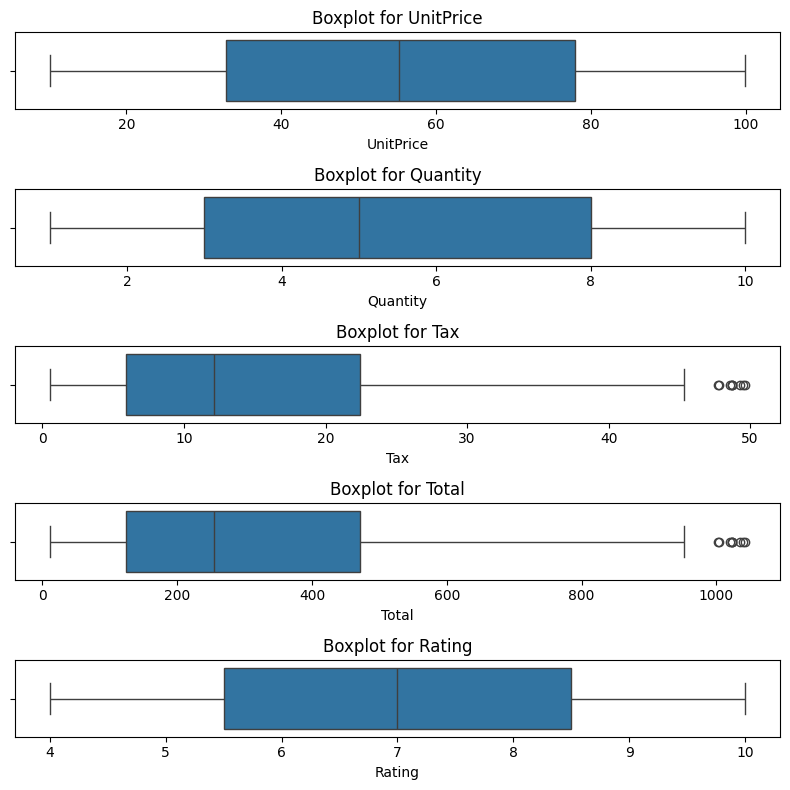

In [101]:
sales_numerical_columns = ['UnitPrice', 'Quantity', 'Tax', 'Total', 'Rating']
# Define the number of subplots you want
nplots = len(sales_numerical_columns)

# Define the figure size
figsize = (8, 8)

# Create a figure
fig, axes = plt.subplots(nrows=nplots, ncols=1, figsize=figsize)

# Iterate over all subplots
for i, column in enumerate(sales_numerical_columns):
    # Create a boxplot in the subplot
    sns.boxplot(x=sales_df[column], ax=axes[i])
    axes[i].set_title('Boxplot for {}'.format(column))

# Automatically adjust subplot params so that the subplot(s) fits into the figure area
fig.tight_layout()

# Display the figure with its subplots
plt.show()

#### **Data Preprocessing**

In [102]:
# Encode categorical variables
sales_data_encoded = pd.get_dummies(sales_df, columns=['Branch','ProductType', 'PaymentType', 'CustomerType'], drop_first=True)

sales_data_encoded['Gender'] = sales_data_encoded['Gender'].replace({'Female': 0, 'Male': 1})

# Standardize numerical features
scaler = RobustScaler()
# Scale all features except the target variable (Gender)
scaled_data = scaler.fit_transform(sales_data_encoded.drop("Gender", axis=1))

# Convert the scaled NumPy array back to a DataFrame
sales_scaled_df = pd.DataFrame(
    scaled_data, columns=sales_data_encoded.drop("Gender", axis=1).columns, index=sales_data_encoded.index)

# Add the target variable (Gender) back to the DataFrame
sales_scaled_df['Gender'] = sales_data_encoded['Gender']

# Display the first few rows of the DataFrame
sales_scaled_df.head()

,UnitPrice,Quantity,Tax,Total,Rating,Branch_B,Branch_C,ProductType_Fashion accessories,ProductType_Food and beverages,ProductType_Health and beauty,ProductType_Home and lifestyle,ProductType_Sports and travel,PaymentType_Credit card,PaymentType_UPI,CustomerType_Normal,Gender
InvoiceID,,,,,,,,,,,,,,,,
750-67-8428,0.431869,0.4,0.850677,0.850677,0.700000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
226-31-3081,-0.886596,0.0,-0.500473,-0.500473,0.866667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
631-41-3108,-0.197514,0.4,0.249843,0.249843,0.133333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1
123-19-1176,0.066356,0.6,0.677951,0.677951,0.466667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
373-73-7910,0.689747,0.4,1.096858,1.096858,-0.566667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1


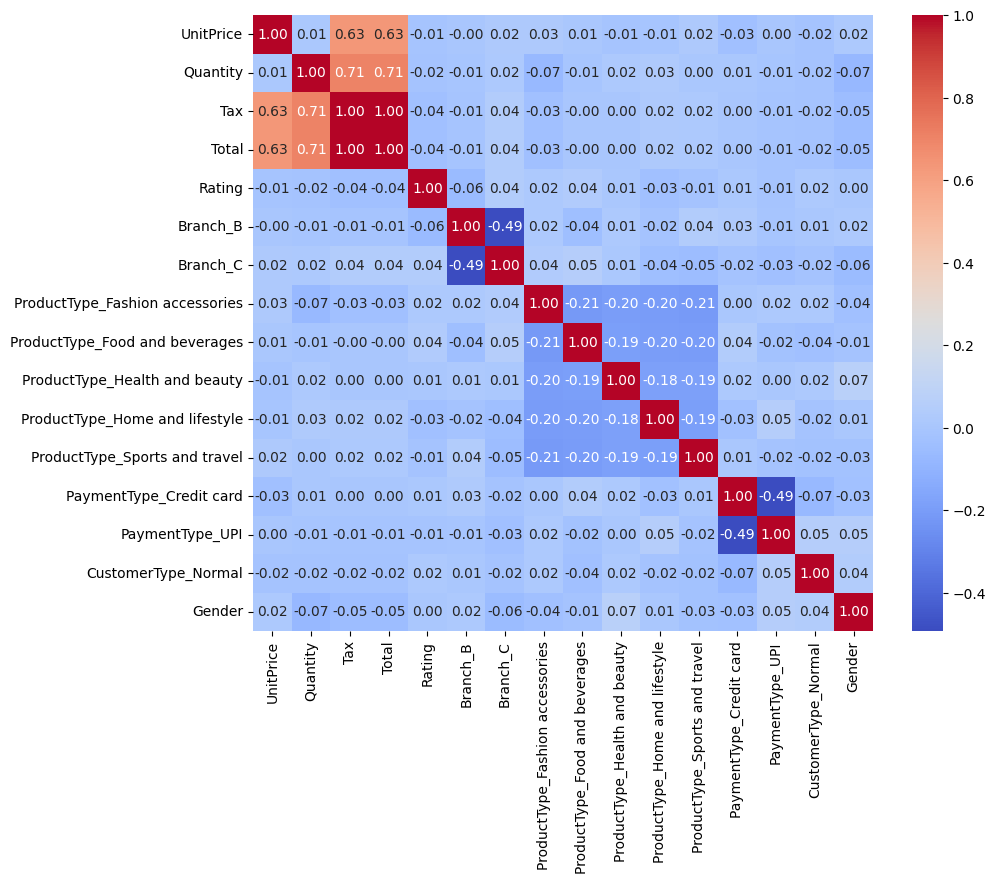

In [103]:
plt.figure(figsize=(10, 8))
sns.heatmap(sales_scaled_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

#### **Task 2.1 : Gender Prediction using decision tree and random forest.**

In [104]:
# PCA
np.random.seed(42)
n_components = 12
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(sales_scaled_df.drop("Gender", axis=1))

# Create a new DataFrame to store PCA results
pca_df = pd.DataFrame(pca_result, columns=[
                      f"PCA{i+1}" for i in range(n_components)], index=sales_scaled_df.index)

# Concatenate the PCA DataFrame with the Gender column
pca_df['Gender'] = sales_scaled_df['Gender']

explained_variance = pca.explained_variance_ratio_

print_message("Amount of variance captured by each component")

# Print the explained variance
for i, exp_var in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {exp_var*100:.2f}% of the variance")

print("\n")
print(f"Percentage of total variance captured by first {n_components} principal components is : {sum(explained_variance)*100}")

____________________________________________________________________________________________________
Amount of variance captured by each component
____________________________________________________________________________________________________
Principal Component 1: 34.43% of the variance
Principal Component 2: 9.15% of the variance
Principal Component 3: 8.97% of the variance
Principal Component 4: 8.60% of the variance
Principal Component 5: 8.05% of the variance
Principal Component 6: 6.38% of the variance
Principal Component 7: 4.56% of the variance
Principal Component 8: 4.38% of the variance
Principal Component 9: 4.21% of the variance
Principal Component 10: 4.02% of the variance
Principal Component 11: 2.98% of the variance
Principal Component 12: 2.79% of the variance


Percentage of total variance captured by first 12 principal components is : 98.52857358360554


____________________________________________________________________________________________________
Decision Tree
____________________________________________________________________________________________________
Best Decision Tree Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 5, 'splitter': 'random'}
Best Decision Tree Accuracy: 0.5250639410904692


Decision Tree Test Accuracy: 0.545


Decision Tree Classifier Evaluation:
              precision    recall  f1-score   support

           0       0.52      0.58      0.55        96
           1       0.57      0.51      0.54       104

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.54       200
weighted avg       0.55      0.55      0.54       200





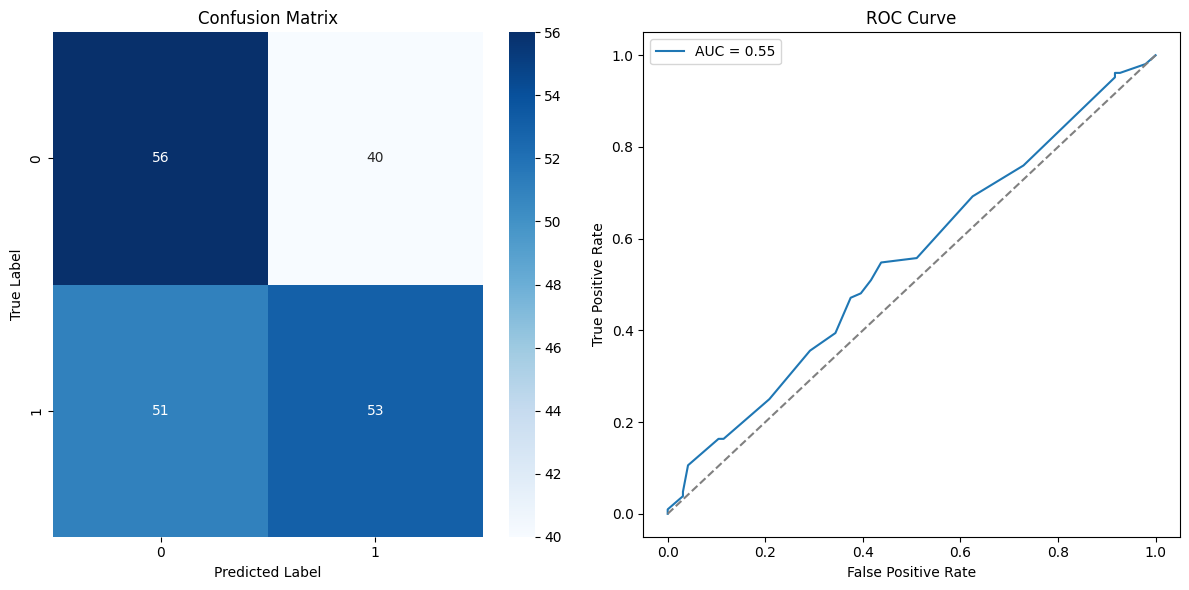

In [105]:

# Set random seeds for NumPy and Python
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)


# Split the data into training and testing sets
X = pca_df.drop(['Gender'], axis=1)
y = pca_df['Gender']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True)
start = time.time()
# Fit Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=random_seed)

dt_param_grid = {
    'max_depth': [2, 3, 5, 10],
    'min_samples_leaf': [5, 10],
    'splitter': ['best', 'random']
}

dt_grid_search = GridSearchCV(
    dt_classifier, dt_param_grid, cv=5, scoring='f1', n_jobs=-1)

dt_grid_search.fit(X_train, y_train)
end = time.time()
sales1_dt = end - start
print_message("Decision Tree")

# Best hyperparameters and accuracy score
print("Best Decision Tree Hyperparameters:", dt_grid_search.best_params_)
print("Best Decision Tree Accuracy:", dt_grid_search.best_score_)
print('\n')

dt_predictions = dt_grid_search.best_estimator_.predict(X_test)
dt_test_accuracy = accuracy_score(
    y_test, dt_predictions)

print("Decision Tree Test Accuracy:", dt_test_accuracy)
print('\n')

print("Decision Tree Classifier Evaluation:")
print(classification_report(y_test, dt_predictions))
print('\n')

# Plot confusion matrix and AUC-ROC curve
roc_and_confusion(X_test, y_test, dt_predictions,
                  dt_grid_search.best_estimator_)

____________________________________________________________________________________________________
Random Forest
____________________________________________________________________________________________________
Best Random Forest Hyperparameters: {'max_depth': 12, 'min_samples_split': 10, 'n_estimators': 100}
Best Random Forest Accuracy: 0.5348133904073096


Random Forest Test Accuracy: 0.54


Random Forest Classifier Evaluation:
              precision    recall  f1-score   support

           0       0.52      0.66      0.58        96
           1       0.58      0.43      0.49       104

    accuracy                           0.54       200
   macro avg       0.55      0.54      0.54       200
weighted avg       0.55      0.54      0.53       200



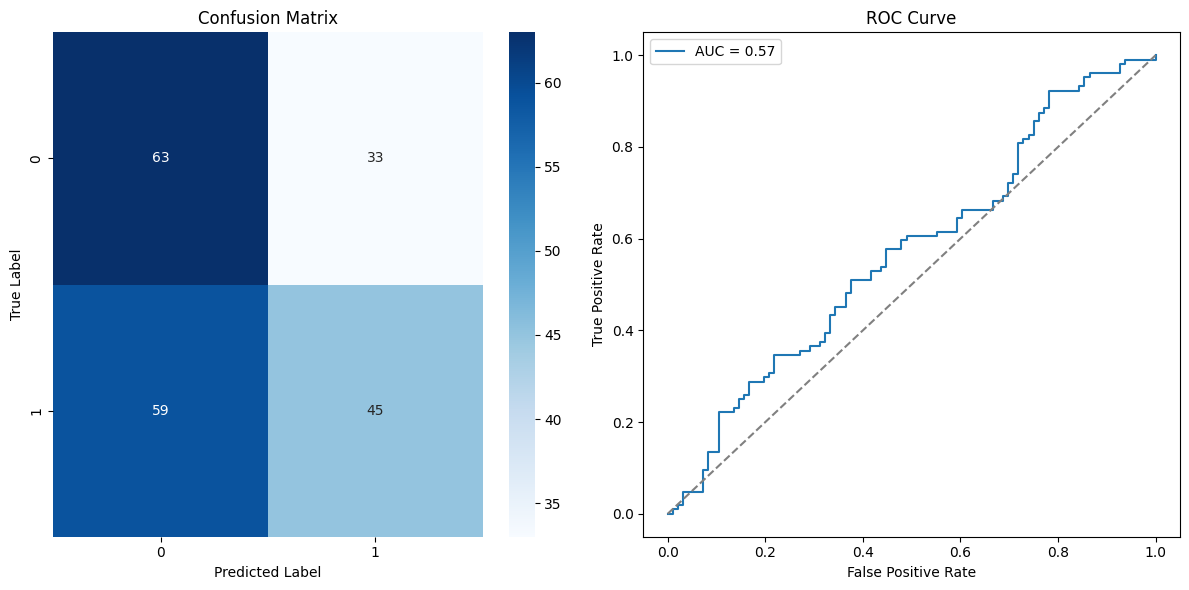

In [106]:
# Random Forest
start = time.time()
rf_classifier = RandomForestClassifier(random_state=random_seed)

# Define hyperparameters for grid search
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 12, None],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search cross-validation
rf_grid_search = GridSearchCV(
    rf_classifier, rf_param_grid, cv=10, scoring='f1', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
end = time.time()
sales1_rf = end - start
print_message("Random Forest")

# Best hyperparameters and accuracy score
print("Best Random Forest Hyperparameters:", rf_grid_search.best_params_)
print("Best Random Forest Accuracy:", rf_grid_search.best_score_)
print('\n')

# Evaluation on the test set
rf_predictions = rf_grid_search.best_estimator_.predict(X_test)
rf_test_accuracy = accuracy_score(
    y_test, rf_predictions)


print("Random Forest Test Accuracy:", rf_test_accuracy)
print("\n")

print("Random Forest Classifier Evaluation:")
print(classification_report(y_test, rf_predictions))

# Plot confusion matrix and AUC-ROC curve
roc_and_confusion(X_test, y_test, rf_predictions,
                  rf_grid_search.best_estimator_)

### Task 2.2: Rating prediction using linear regression and decision tree regressor.


In [107]:
# PCA
np.random.seed(42)
n_components = 12
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(sales_scaled_df.drop("Rating", axis=1))

# Create a new DataFrame to store PCA results
pca_df = pd.DataFrame(pca_result, columns=[
                      f"PCA{i+1}" for i in range(n_components)], index=sales_scaled_df.index)

# Concatenate the PCA DataFrame with the Rating column
pca_df['Rating'] = sales_scaled_df['Rating']

explained_variance = pca.explained_variance_ratio_

print_message("Amount of variance captured by each component")

# Print the explained variance
for i, exp_var in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {exp_var*100:.2f}% of the variance")

print("\n")
print(f"Percentage of total variance captured by first {n_components} principal components is : {sum(explained_variance)}")

____________________________________________________________________________________________________
Amount of variance captured by each component
____________________________________________________________________________________________________
Principal Component 1: 35.15% of the variance
Principal Component 2: 9.30% of the variance
Principal Component 3: 8.87% of the variance
Principal Component 4: 8.78% of the variance
Principal Component 5: 6.67% of the variance
Principal Component 6: 6.37% of the variance
Principal Component 7: 4.64% of the variance
Principal Component 8: 4.47% of the variance
Principal Component 9: 4.29% of the variance
Principal Component 10: 4.06% of the variance
Principal Component 11: 3.04% of the variance
Principal Component 12: 2.85% of the variance


Percentage of total variance captured by first 12 principal components is : 0.9849550762896246


In [108]:
# Set random seeds for NumPy and Python
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)


# Split the data into training and testing sets
X = pca_df.drop('Rating', axis=1)
y = pca_df['Rating']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20)

start = time.time()
# Linear Regression Model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)
end = time.time()
sales2_lr = end - start

# Decision Tree Regressor Model
start = time.time()
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)
end = time.time()
sales2_dt = end - start

# Making predictions
linear_reg_pred = linear_reg_model.predict(X_test)
decision_tree_pred = decision_tree_model.predict(X_test)

# Evaluation Metrics
linear_reg_mae = mean_absolute_error(y_test, linear_reg_pred)
linear_reg_mse = mean_squared_error(y_test, linear_reg_pred)
linear_reg_r2 = r2_score(y_test, linear_reg_pred)

decision_tree_mae = mean_absolute_error(y_test, decision_tree_pred)
decision_tree_mse = mean_squared_error(y_test, decision_tree_pred)
decision_tree_r2 = r2_score(y_test, decision_tree_pred)

print_message("Results using default values")

# Printing the evaluation metrics
print("Linear Regression Model Evaluation:")
print(f"Mean Absolute Error (MAE): {linear_reg_mae:.4f}")
print(f"Mean Squared Error (MSE): {linear_reg_mse:.4f}")
print(f"R-squared (R2) Score: {linear_reg_r2:.4f}")
print("\n")

print("Decision Tree Regressor Model Evaluation:")
print(f"Mean Absolute Error (MAE): {decision_tree_mae:.4f}")
print(f"Mean Squared Error (MSE): {decision_tree_mse:.4f}")
print(f"R-squared (R2) Score: {decision_tree_r2:.4f}")

____________________________________________________________________________________________________
Results using default values
____________________________________________________________________________________________________
Linear Regression Model Evaluation:
Mean Absolute Error (MAE): 0.5111
Mean Squared Error (MSE): 0.3472
R-squared (R2) Score: -0.0186


Decision Tree Regressor Model Evaluation:
Mean Absolute Error (MAE): 0.7152
Mean Squared Error (MSE): 0.7315
R-squared (R2) Score: -1.1461


**Linear Regression Model:**
* The R-squared (R2) score being negative (-0.0186) indicates that the model performs worse than a horizontal line, suggesting that it doesn't capture the variance in the data well. This could be due to the linear regression assumption not being met, or the relationship between the features and the target variable not being linear.

**Decision Tree Regressor Model:**
* The negative R-squared (R2) score (-1.1461) indicates that the decision tree regressor performs even worse than the linear regression model. This might be due to overfitting, where the model captures noise in the training data rather than the underlying patterns.


#### Testing for Linear Regression assumptions

In [109]:
# Assuming the dependent variable is the last column
X = pca_df.iloc[:, :-1]
y = pca_df.iloc[:, -1]

# Add a constant to the independent value
X1 = sm.add_constant(X)

# make regression model
model = sm.OLS(y, X1)

# fit model and print results
results = model.fit()
print(results.summary())
print("\n")

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6715
Date:                Sun, 17 Mar 2024   Prob (F-statistic):              0.780
Time:                        14:30:29   Log-Likelihood:                -857.26
No. Observations:                1000   AIC:                             1741.
Df Residuals:                     987   BIC:                             1804.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0091      0.018     -0.501      0.6

The model’s R-squared and adjusted R-squared values are very low, indicating that the model explains very little of the variability in the response variable. The F-statistic's p-value is high, suggesting that the predictors are not collectively significant. The coefficient's p-values are also high, indicating that they are not individually significant. The model's assumptions of normality (as indicated by the Omnibus and JB tests) and no autocollinearity (as indicated by the Cond. No.) appear to be met. However, given the low explanatory power and lack of significance of the predictors, this model may not be the best fit for the given data.

##### **Hyperparameter tuning**

In [110]:
print_message("Results after hyperparameter tuning")
# Create a model
model = LinearRegression()

# Create the RFE object and rank each feature
rfe = RFE(estimator=model, n_features_to_select=5)
fit = rfe.fit(X_train, y_train)

X_train_rfe = fit.transform(X_train)
X_test_rfe = fit.transform(X_test)

# Fit the model
model.fit(X_train_rfe, y_train)

# Make predictions
y_pred_test_lr = model.predict(X_test_rfe)

# Calculate metrics on the test set
mae_test = mean_absolute_error(y_test, y_pred_test_lr)
mse_test = mean_squared_error(y_test, y_pred_test_lr)
r2_test = r2_score(y_test, y_pred_test_lr)

print("Linear Regression Model Evaluation:")
print(f"MAE: {mae_test}")
print(f"MSE: {mse_test}")
print(f"R2 Score: {r2_test}\n")

# Fit Decision Tree Classifier
dt_classifier = DecisionTreeRegressor(random_state=random_seed)

dt_param_grid = {
    'max_depth': [3, 5, 10, 12],
    'min_samples_leaf': [3, 5, 10],
    'splitter': ['best', 'random']
}

# Initialize Grid Search
grid = GridSearchCV(dt_classifier, dt_param_grid, cv=10, scoring='neg_mean_absolute_error')

# Fit the data to Grid Search
grid.fit(X_train, y_train)

# Get the best parameters
best_params = grid.best_params_

print("Best parameters: ", best_params)

# Create a new model with the best parameters
best_model = DecisionTreeRegressor(max_depth=best_params['max_depth'],
                                   min_samples_leaf=best_params['min_samples_leaf'],
                                   splitter=best_params['splitter'],
                                   random_state=42)

# Fit the model
best_model.fit(X_train, y_train)

# Make predictions
y_pred_test_dt = best_model.predict(X_test)

# Calculate metrics on the test set
mae_test = mean_absolute_error(y_test, y_pred_test_dt)
mse_test = mean_squared_error(y_test, y_pred_test_dt)
r2_test = r2_score(y_test, y_pred_test_dt)

print("Decision Tree Regressor Model Evaluation:")
print(f"MAE: {mae_test}")
print(f"MSE: {mse_test}")
print(f"R2 Score: {r2_test}")

____________________________________________________________________________________________________
Results after hyperparameter tuning
____________________________________________________________________________________________________
Linear Regression Model Evaluation:
MAE: 0.508777805146505
MSE: 0.34687758691570925
R2 Score: -0.017634227212133702

Best parameters:  {'max_depth': 3, 'min_samples_leaf': 10, 'splitter': 'random'}
Decision Tree Regressor Model Evaluation:
MAE: 0.5070869154564841
MSE: 0.3491380962484285
R2 Score: -0.0242658798604396


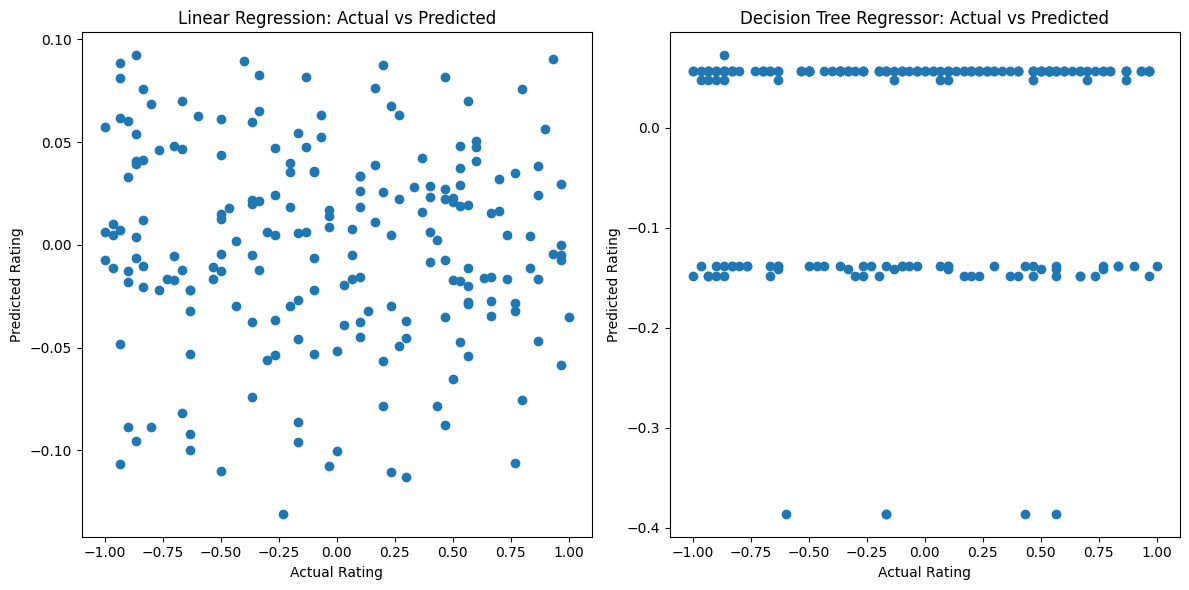

In [111]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test_lr)
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test_dt)
plt.title('Decision Tree Regressor: Actual vs Predicted')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

plt.tight_layout()
plt.show()

The plots shows a wide dispersion of points, indicating that the linear and decision tree regression model's predictions are not closely matching the actual ratings. This lack of a clear trend suggests that the model may not be capturing the underlying relationship effectively.

In [112]:
project_end = time.time()

In [113]:
project_time = project_end - project_start

In [114]:
print(project_time)

411.7032654285431


<div align="center">
<h2><b><u>Total Times taken for every model and the project</u></b></h2>
</div>

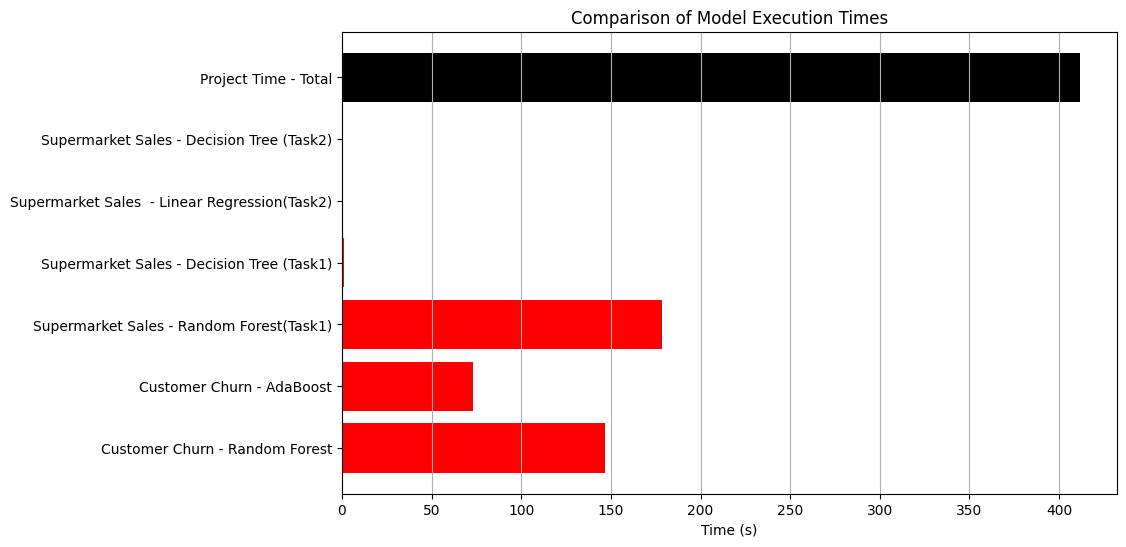

In [123]:
data = {
    'Dataset': ['Customer Churn', 'Customer Churn', 'Supermarket Sales', 'Supermarket Sales', 'Supermarket Sales ', 'Supermarket Sales', 'Project Time'],
    'Model': ['Random Forest', 'AdaBoost', 'Random Forest(Task1)', 'Decision Tree (Task1)', 'Linear Regression(Task2)', 'Decision Tree (Task2)' ,'Total'],
    'Time (s)': [customer_churn_rf, customer_churn_ab, sales1_rf, sales1_dt, sales2_lr, sales2_dt, project_time],
       }

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
colors = ['red' if x != 'Total' else 'black' for x in df['Model']]
plt.barh(df['Dataset'] + ' - ' + df['Model'], df['Time (s)'], color = colors)
plt.xlabel('Time (s)')
plt.title('Comparison of Model Execution Times')
plt.grid(axis='x')
plt.show()

In [126]:
# Creating table
table = tabulate(df, headers='keys', tablefmt='grid')
print(table)

+----+-------------------+--------------------------+-------------+
|    | Dataset           | Model                    |    Time (s) |
+====+===================+==========================+=============+
|  0 | Customer Churn    | Random Forest            | 146.726     |
+----+-------------------+--------------------------+-------------+
|  1 | Customer Churn    | AdaBoost                 |  73.2157    |
+----+-------------------+--------------------------+-------------+
|  2 | Supermarket Sales | Random Forest(Task1)     | 178.601     |
+----+-------------------+--------------------------+-------------+
|  3 | Supermarket Sales | Decision Tree (Task1)    |   1.00377   |
+----+-------------------+--------------------------+-------------+
|  4 | Supermarket Sales | Linear Regression(Task2) |   0.0126338 |
+----+-------------------+--------------------------+-------------+
|  5 | Supermarket Sales | Decision Tree (Task2)    |   0.0232201 |
+----+-------------------+----------------------

<div align="center">
<h2><b><u>Report</u></b></h2>
</div>

## **Task 1**

### Adaboost and Random forest

#### Introduction

This report presents an evaluation of two classifiers, Random Forest and AdaBoost, applied to a dataset containing information about customer behavior and churn. The objective is to predict customer churn based on various features such as age, gender, annual income, and satisfaction score.

#### Dataset Overview

The dataset consists of 1000 entries with 14 columns. It includes features such as age, gender, annual income, total spend, and churn status. The dataset has been preprocessed, including encoding categorical variables, converting certain features to numeric values, and standardizing numerical features.

#### Model Fitting

##### Random Forest Classifier:
- The Random Forest model was trained using a grid search over hyperparameters such as the number of estimators, maximum depth, and minimum samples split.
- The best hyperparameters found were max_depth=5, min_samples_split=5, and n_estimators=250.
- The best accuracy achieved on the training set was approximately 63.06%.
- The test accuracy of the Random Forest classifier was found to be approximately 58.5%.

##### AdaBoost Classifier:
- The AdaBoost model was trained using a decision tree classifier with a grid search over hyperparameters including the number of estimators and learning rate.
- The best hyperparameters found were learning_rate=0.01 and n_estimators=100.
- The best accuracy achieved on the training set was approximately 61.63%.
- The test accuracy of the AdaBoost classifier was approximately 59.5%.

#### Model Evaluation

##### Random Forest Classifier Evaluation:
- Precision for churn (class 1) was 57%, recall was 88%, and F1-score was 69%.
- Precision for non-churn (class 0) was 65%, recall was 26%, and F1-score was 37%.
- The AUC-ROC curve indicated moderate performance.

##### AdaBoost Classifier Evaluation:
- Precision for churn (class 1) was 57%, recall was 92%, and F1-score was 71%.
- Precision for non-churn (class 0) was 72%, recall was 22%, and F1-score was 34%.
- The AUC-ROC curve indicated moderate performance.

#### Comparative Evaluation

- Both classifiers achieved similar test accuracies, with AdaBoost slightly outperforming Random Forest.
- AdaBoost showed higher recall for churned customers (class 1), indicating its ability to better identify customers likely to churn.
- Random Forest exhibited higher precision for non-churned customers (class 0), suggesting its strength in correctly classifying non-churn cases.

#### Conclusion

In conclusion, both Random Forest and AdaBoost classifiers showed moderate performance in predicting customer churn. While AdaBoost demonstrated better recall for churned customers, Random Forest exhibited higher precision for non-churned customers. Depending on the specific requirements of the business, either classifier could be chosen for deployment. Further fine-tuning and feature engineering may help improve the performance of both models.


## **Task 2**

## **Task 2.1**

### Decision Tree and Random Forest

#### Introduction

This report presents an evaluation of two classifiers, Decision Tree and Random Forest, applied to a dataset containing sales information and gender classification. The objective is to predict the gender of customers based on various features such as unit price, quantity, total, and ratings.

#### Dataset Overview

The dataset consists of 1000 entries with 10 columns. It includes features such as branch, customer type, gender, product type, unit price, quantity, tax, total, payment type, and rating. The dataset has been preprocessed, including encoding categorical variables and standardizing numerical features.

#### Model Fitting

##### Decision Tree Classifier:

- The Decision Tree model was trained using grid search over hyperparameters such as max_depth, min_samples_leaf, and splitter.
- The best hyperparameters found were max_depth=5, min_samples_leaf=5, and splitter='random'.
- The best F1-score achieved on the training set was approximately 52.51%.
- The test accuracy of the Decision Tree classifier was found to be approximately 54.5%.

##### Random Forest Classifier:

- The Random Forest model was trained using grid search over hyperparameters such as n_estimators, max_depth, and min_samples_split.
- The best hyperparameters found were max_depth=12, min_samples_split=10, and n_estimators=100.
- The best F1-score achieved on the training set was approximately 53.48%.
- The test accuracy of the Random Forest classifier was found to be approximately 54%.

#### Model Evaluation

##### Decision Tree Classifier Evaluation:

- Precision for gender class 0 was 0.52, recall was 0.58, and F1-score was 0.55.
- Precision for gender class 1 was 0.57, recall was 0.51, and F1-score was 0.54.
- The AUC-ROC curve indicated fair performance.

##### Random Forest Classifier Evaluation:

- Precision for gender class 0 was 0.52, recall was 0.66, and F1-score was 0.58.
- Precision for gender class 1 was 0.58, recall was 0.43, and F1-score was 0.49.
- The AUC-ROC curve indicated fair performance.

#### Comparative Evaluation

- Both classifiers achieved similar test accuracies, with Random Forest slightly outperforming Decision Tree in f1 score.
- Decision Tree showed slightly higher precision for gender class 1, indicating its ability to better identify male customers.
- Random Forest exhibited higher recall for gender class 0, suggesting its strength in correctly classifying female customers.

#### Conclusion

In conclusion, both Decision Tree and Random Forest classifiers showed fair performance in predicting the gender of customers based on sales information. While Random Forest demonstrated better recall for female customers, Decision Tree exhibited slightly higher precision for male customers. Further fine-tuning and feature engineering may help improve the performance of both models.


## **Task 2.2**

### Linear regression and decision tree regressor

#### Introduction

This report presents the evaluation of two regression models, Linear Regression and Decision Tree Regressor, applied to a dataset containing supermarket sales information to predict the ratings of products. The objective is to understand how well these models can predict the rating based on principal components derived from the sales data.

#### Dataset Overview

The dataset consists of 1000 entries with 10 columns, including features such as branch, customer type, gender, product type, unit price, quantity, tax, total, payment type, and rating. The dataset has been preprocessed, including encoding categorical variables, standardizing numerical features, and applying Principal Component Analysis (PCA) to reduce dimensionality.

##### PCA Analysis:

The PCA analysis revealed that the first 12 principal components capture approximately 98% of the total variance in the data.

#### Model Fitting

##### Linear Regression Model:

- The Linear Regression model was fitted using the principal components derived from the sales data.
- The model achieved an R-squared (R2) score of approximately -0.02, indicating poor performance.
- The Mean Absolute Error (MAE) for the test set was approximately 0.51.

##### Decision Tree Regressor Model:

- The Decision Tree Regressor model was also fitted using the principal components.
- Hyperparameter tuning was performed using grid search over parameters such as max_depth, min_samples_leaf, and splitter.
- The best hyperparameters found were max_depth=3, min_samples_leaf=10, and splitter='random'.
- The model achieved an R2 score of approximately -0.02, similar to Linear Regression.
- The MAE for the test set was approximately 0.51.

#### Model Evaluation

##### Linear Regression Model Evaluation:

- The Linear Regression model exhibited poor performance, with an R2 score close to zero and a relatively high MAE.
- The scatter plot of actual vs. predicted ratings showed a wide dispersion of points, indicating the model's inability to accurately predict ratings.

##### Decision Tree Regressor Model Evaluation:

- The Decision Tree Regressor model also showed poor performance, with an R2 score similar to Linear Regression and a slightly lower MAE.
- The scatter plot of actual vs. predicted ratings exhibited similar dispersion, suggesting ineffective prediction by the model.

#### Conclusion

In conclusion, both Linear Regression and Decision Tree Regressor models showed inadequate performance in predicting the ratings of products based on supermarket sales data. The wide dispersion of points in the scatter plots indicates that these models are unable to capture the underlying relationship between features and ratings effectively. Further analysis and feature engineering may be required to improve the predictive performance of the models.

#### Concluding Remarks on time taken by different models

Among the models tested, the Random Forest (Task1) for the Supermarket Sales dataset took the most time, followed by the Random Forest model for the Customer Churn dataset.
The models for the Supermarket Sales dataset generally took less time compared to the Customer Churn dataset models.
The Decision Tree models for both datasets took significantly less time compared to the Random Forest models.
Overall, the Random Forest models tend to take more time compared to other models, particularly when dealing with larger datasets or more complex tasks.
The AdaBoost model for the Customer Churn dataset took approximately 73.216 seconds to train. Compared to other models like Random Forest, which took longer, AdaBoost's training time is relatively shorter but much more than that of Decision Trees. However, it's important to note that AdaBoost typically requires more computational resources compared to simpler models due to its iterative nature and sequential training process